In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

from scipy.interpolate import  griddata
import h5py
from scipy.spatial import KDTree
from datagenerering import lagra_tre, tre_objekt
import pickle
tan= -0.035 
cos = 1/(1+tan)**.5
sin = tan/(1+tan)**.5

rot = np.asarray([[cos,-sin,0],[sin,cos,0],[0,0,1]])

def norm(v):
    # with np.errstate(over='raise'):
    nemnar = np.hypot(v[0],v[1])
    # nemnar = np.sqrt(np.square(v).sum(axis=0))
    return np.divide(v , nemnar, out=np.zeros_like(v), where=nemnar!=0)

# Importer csv-filene

In [2]:
steps = [15,22,23,30,37,38,45,52,60,67,75,90,105,120,135,150,165,172,180,187,195,202,210,217,225,232,240,247,255,262,270,277,285,292,300,307,315,322,323,330,337,338,345,352,353,360,367,368,375,382,383,390,397,398,405,412,413,420,427,428,435,442,443,450,457,458,465,472,473,480,487,488,495,502,503,510,517,518,525,532,533,540,547,548,555,562,563,570,577,578,585,592,593,600,607,608,615,622,623,630,637,638,645,652,660,667,675,682,690,697,705,712,720,727,735,742,750,757,765,772,780,787,795,802,810,817,825,832,840,847,855,862,870,877,885,892,900,907,915,922,930,937,945,952,960,967,975,982,990,997,1005,1012,1020,1027,1035,1042,1050,1057,1065,1072,1080,1087,1095,1102,1110,1117,1125,1132,1140,1147,1155,1162,1170,1177,1185,1192,1200,1207,1215,1222,1230,1237,1245,1252,1260,1267,1275,1290,1305,1320,1335,1350,1365,1380,1395,1410,1425,1440,1455,1470,1485]
times = np.asarray(steps)*.2

In [18]:
a = pd.read_csv(f"richter/export_ts_15.csv",skiprows=5)
a.iloc[:,:3] = np.einsum( 'ni,ij->nj',a.iloc[:,:3], rot )
b=a[(a['X [ m ]']>19.23734) & (a[' Z [ m ]']<5.3) & (a['X [ m ]'] < 194.98135)]
# b = a[a['X [ m ]']>0.02]
# b = b[b[' Z [ m ]']<5.3]
xy=b[['X [ m ]',' Z [ m ]']].to_numpy()


In [19]:
uv = []
vel = []
for s in steps:
    filnamn = f"richter/export_ts_{s}.csv"
    a = pd.read_csv(filnamn,skiprows=5)
    a.iloc[:,:3] = np.einsum( 'ni,ij->nj',a.iloc[:,:3], rot )
    a.iloc[:,4:7] = np.einsum( 'ni,ij->nj',a.iloc[:,4:7], rot )
    b=a[(a['X [ m ]']>19.23734) & (a[' Z [ m ]']<5.3) & (a['X [ m ]'] < 194.98135)]
    uv.append(b[[' Velocity u [ m s^-1 ]',' Velocity w [ m s^-1 ]']].to_numpy())
    vel.append(b[' Velocity [ m s^-1 ]'].to_numpy())
# a.to_csv("csv/export_ts_15_transformed.csv",sep=";",encoding='cp1252')
vel = np.asarray(vel)
uv = np.asarray(uv)

# Lag hdf5-fila

In [20]:


with h5py.File("data/richter.hdf5", 'w') as f:
    f.create_dataset("x", data=xy*1000, compression="gzip", compression_opts=9)
    f.create_dataset("U", data=uv*1000, compression="gzip", compression_opts=9)
    f.create_dataset("t", data=np.asarray(times), compression="gzip", compression_opts=9)
    # f.attrs.create('I', data=I)
    # f.attrs.create('J', data=J)

# PLott alle fartsbileta som png

In [15]:
x,y = np.mgrid[0:250:1000j,-25:6:124j]

myDPI  =150
length = 250
pts = length * 76
for i in range(times.shape[0]):
    resampled=griddata((xy), vel[i],(x,y), method='linear') # np.linalg.norm(uv[i],axis=1)
    fig,ax = plt.subplots(figsize=(1920/myDPI,1080/myDPI),dpi=myDPI)
    ax.imshow(resampled.T[:,:pts],extent=(0,length,-25,6),origin='lower')
    # plt.show()
    fig.savefig(f"richter/flow{i:03d}.png")
    plt.close()

# Les golv-fila

In [3]:
golv = pd.read_csv("richter/export_golv.csv",skiprows=5)
# golv.iloc[:,:3] = 
golv.iloc[:,:3] = np.einsum( 'ni,ij->nj',golv.iloc[:,:3], rot )
golv = golv[['X [ m ]',' Z [ m ]']]
golv_nede = golv[golv[' Z [ m ]']<2]
golv_oppe = golv[golv[' Z [ m ]']>2]
golv_array = np.flip(golv_nede.to_numpy()[157:], axis=0)

ga = golv.to_numpy()

In [4]:
tak = pd.read_csv("richter/export_tak.csv",skiprows=5)
# golv.iloc[:,:3] = 
tak.iloc[:,:3] = np.einsum( 'ni,ij->nj',tak.iloc[:,:3], rot )
tak = tak[['X [ m ]',' Z [ m ]']]
tak_array = tak.to_numpy()[1882:]
# tak = tak[tak[' Z [ m ]']<2]

In [5]:
rand =  np.vstack(( ga[317:] ,ga[:157], ga[289:317], np.flip(ga[158:289],axis=0), np.flip(tak_array, axis=0) ))
# ga[157] er det same punktet som tak_array[-1], så eg måtte ta vekk ga[157].


In [35]:
with h5py.File("walls.hdf5","w") as f:
    f.create_dataset("alle",  data=rand*1000, compression="gzip", compression_opts=9)


In [54]:
tre = KDTree(rand)

In [113]:
data = (50.1, -8.2)
distances, numbers = tre.query(data,2)
v = data - rand[numbers[0]]
# numbers = np.sort(numbers)

print(numbers)
normal = norm(np.cross(rand[sorted(numbers)[1]]-rand[sorted(numbers)[0]],np.array([0,0,1]))[:2,None])
print(normal, rand[numbers[0]],rand[numbers[1]],rand[numbers[1]]-rand[numbers[0]])
print(np.dot(v, normal))
print(distances)

[1229 1230]
[[0.04294602]
 [0.99907739]] [50.03039845 -8.26670551] [50.00495138 -8.26561165] [-0.02544708  0.00109386]
[0.06963308]
[0.0964054  0.11549515]


In [6]:
np.partition(np.linalg.norm(np.diff(rand,axis=0),axis=1), -10)[-10:]

array([0.39910684, 0.41788464, 0.39945522, 0.45422221, 0.40019195,
       8.64999962, 1.01859715, 0.42969724, 0.41811632, 0.42524148])

In [ ]:
np.max(np.linalg.norm(np.diff(rand,axis=0),axis=1))

8.64999962

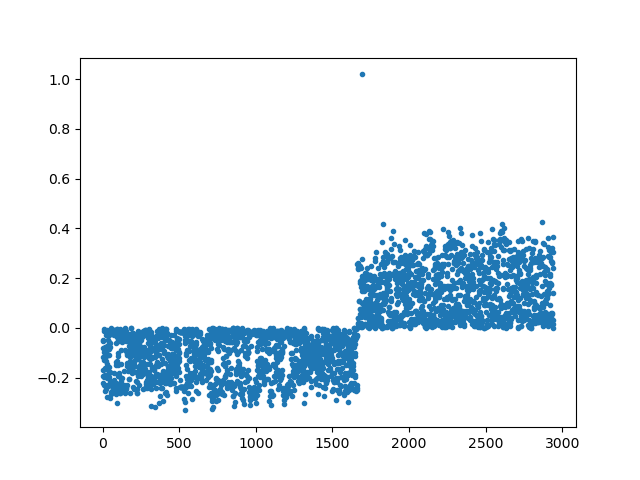

In [8]:
fig2,ax2 =plt.subplots()

ax2.plot(range(2943),np.diff(rand,axis=0)[:,0],'.')

In [14]:
rand[1821:1824]

array([[19.23085696,  4.4884963 ],
       [19.24000355,  4.48910284],
       [19.23793708,  4.91879511]])

In [13]:
with h5py.File("walls.hdf5","w") as f:
    f.create_dataset("ceiling",  data=tak_array, compression="gzip", compression_opts=9)
    f.create_dataset("floor",  data=golv_array, compression="gzip", compression_opts=9)

(-9.749170456455113, 204.73257958618308, -12.0068722215, 5.8694086515)

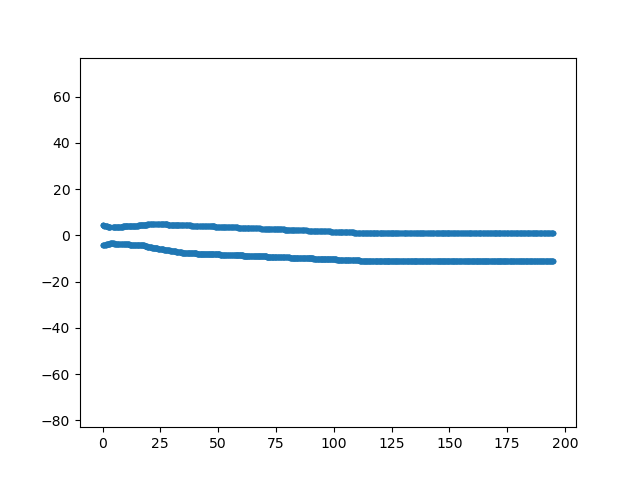

In [5]:
fig,ax =plt.subplots()
# ax.plot(golv_array[:,0],golv_array[:,1],'.')
# ax.plot(golv_nede.iloc[:,0],golv_nede.iloc[:,1],'.')
# ax.plot(golv_oppe.iloc[:,0],golv_oppe.iloc[:,1],'.')
# ax.plot(tak.iloc[:,0],tak.iloc[:,1],'o')
# ax.plot(tak_array[:,0],tak_array[:,1],'orange')
# ax.scatter(rand[:,0],rand[:,1],np.arange(2945)**1.3*.01)
ax.plot(rand[:,0],rand[:,1],'.')

ax.axis('equal')
# ax.annotate('1822', xy=rand[1822], xytext=(0, 30),
#             arrowprops=dict(facecolor='black', shrink=0.05))
# ax.set_xlim(17,22)

# Her byrjar import av hdf5-fila

In [6]:
with h5py.File("data/richter.hdf5", 'r') as f:
    xy = np.asarray(f['x'])
    uv= np.asarray(f['U'])
    t= np.asarray(f["t"])

txy = np.column_stack((np.repeat(t,xy.shape[0]),np.tile(xy,(len(t),1))))

u = uv[:,:,0]
v = uv[:,:,1]
u_r=u.ravel()
v_r = v.ravel()
uv_ny = np.stack((u_r,v_r),1)

tree = KDTree(txy)
tre_obj = tre_objekt(tree, uv_ny)


In [17]:
uv[182,:,0].shape

(40450,)

array([ 2.64818632e+02, -2.73974638e-02])

(10450.159063336008, 203768.359833466, -12006.4576815, 5869.388911499999)

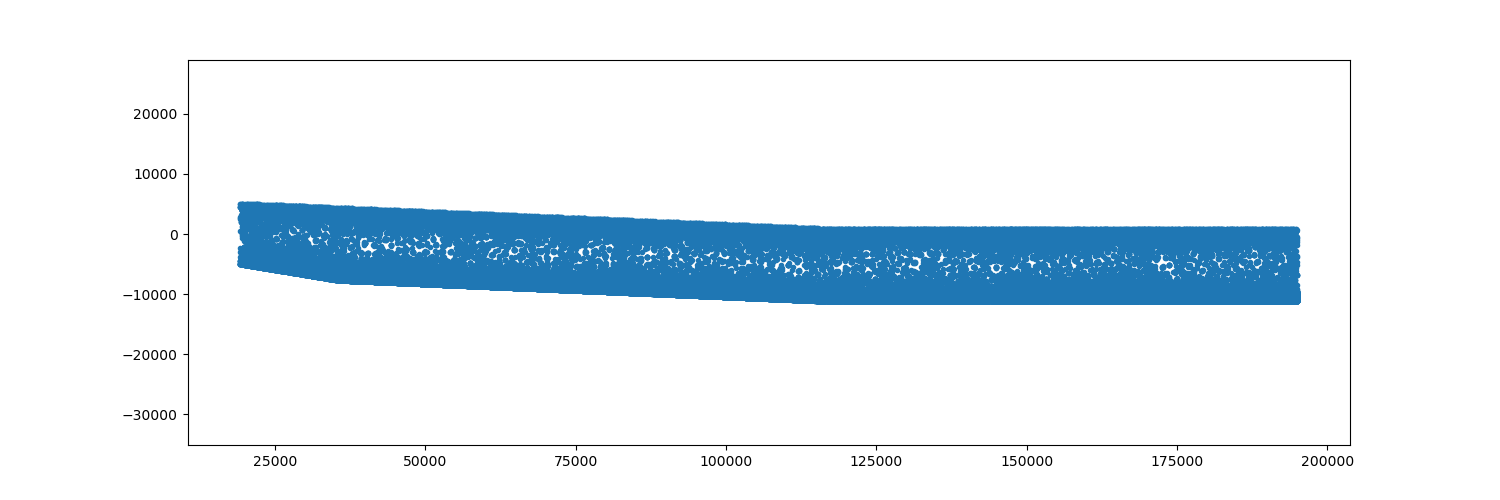

In [8]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(xy[:,0],xy[:,1],'.')
ax.axis('equal')

In [9]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [11]:
vor = Voronoi(xy)


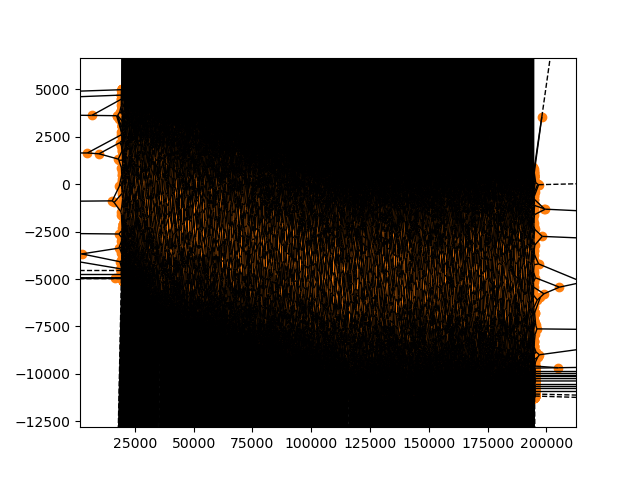

In [12]:
fig = voronoi_plot_2d(vor)
plt.show()

(-11096.0, -11084.0)

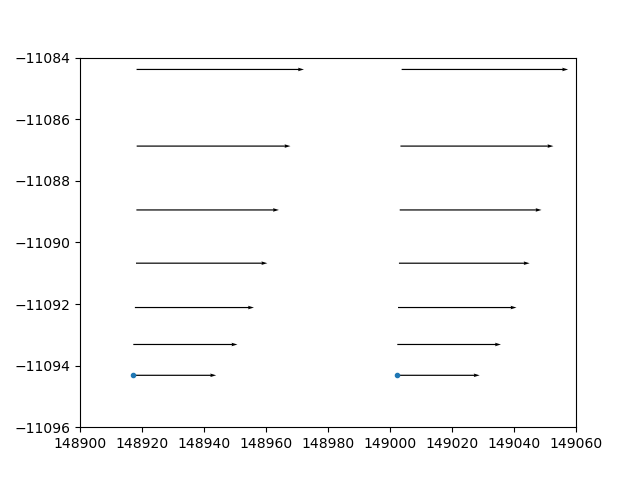

In [38]:
fig, ax = plt.subplots()
ax.quiver(xy[:,0],xy[:,1],uv[182,:,0],uv[182,:,1],scale=1000)
ax.plot(rand[:,0]*1e3,rand[:,1]*1e3,'.')
ax.set_xlim(148900,149060)
ax.set_ylim(-11096,-11084)

In [34]:
uv_ny[tree.query((249,148958,-11094.2878))[1]]

array([ 2.64818632e+02, -2.73974638e-02])

In [46]:
np.where((xy[:,0] > 148900) & (xy[:,0] < 148960) & (xy[:,1] > -11096) & (xy[:,1] < -11094))

(array([28324]),)

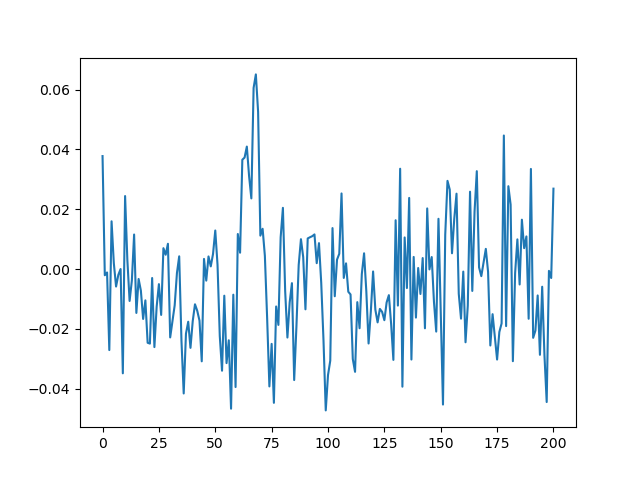

In [54]:
# (xy[:,0] > 148900) & (xy[:,0] < 148960) & (xy[:,1] > -11096) & (xy[:,1] < -11094)
fig_to,ax_to = plt.subplots()
ax_to.plot(range(201),uv[:,28324,1])


In [56]:
np.mean(uv[:,28324,0])

169.50250978214524

In [44]:
xy[(xy[:,0] > 148900) & (xy[:,0] < 148960) & (xy[:,1] > -11096) & (xy[:,1] < -11094)]

array([[148917.03737751, -11094.3146    ]])

In [37]:
rand

array([[194.98340911, -11.194314  ],
       [194.9311068 , -11.1939192 ],
       [194.71149647, -11.1922607 ],
       ...,
       [194.74459156,   0.90566576],
       [194.9832216 ,   0.90568566],
       [194.98340913,   0.90568566]])

In [23]:
lagra_tre(tre_obj, "data/richter.pickle")

# Sjå på partikkelsimulering

In [7]:
with open("runs/richter/RK45_100_[0.05, 0.06]_1_1e-02_NN_23.01.24.pickle", 'rb') as f:
    sti = pickle.load(f) 
stien = sti[0].sti_dict

In [22]:
for j in sti:
    stien = j.sti_dict
    for i in range(stien['init_time'],stien['final_time']):
        if round(stien[i]['position'][0]) == 161271:
            print(j.index, i, stien['final_time'], stien[i]['position'][:2], stien[stien['final_time']]['position'][:2] ) 

1 14848 14849 [161271.25140002  -1327.91550292] [161281.20653296  -1329.32975131]
19 13017 14849 [161270.63557996 -10157.86291789] [184295.71207406  -7386.63961743]
28 12296 14734 [161271.20000942  -4452.89391244] [194969.30900573  -6267.8342909 ]
32 13196 14849 [161271.11844263  -4270.40535237] [187163.80201613  -4121.68854461]
46 10854 13421 [161270.74905998  -2094.30463775] [194977.93330583  -1434.12929082]
64 11516 13646 [161270.69451878  -7387.48113059] [194969.13679975  -7089.16332435]
90 10891 13482 [161271.46855033  -1958.78820216] [194974.33805993  -1547.99994031]
91 12796 14849 [161271.3923775   -3927.92415899] [191794.17707182  -3937.02790575]
98 10926 13383 [161270.69973632  -2316.31164092] [194967.7989786   -1769.70274898]


(-9749.170456455113, 204732.57958618307, -12006.8722215, 5869.4086515)

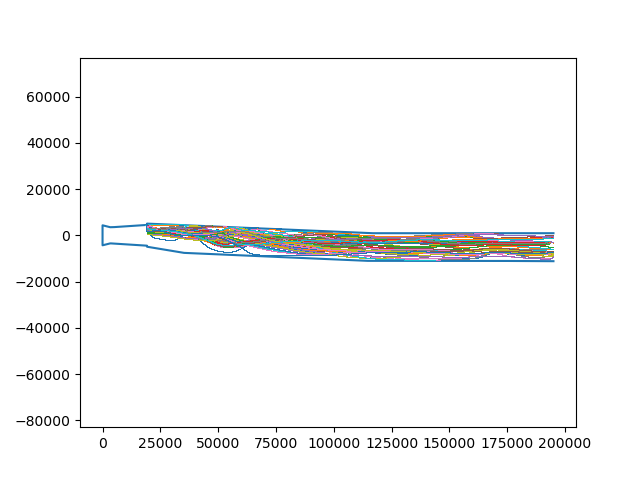

In [23]:
fig_part,ax_part =plt.subplots()
# ax.plot(golv_array[:,0],golv_array[:,1],'.')
# ax.plot(golv_nede.iloc[:,0],golv_nede.iloc[:,1],'.')
# ax.plot(golv_oppe.iloc[:,0],golv_oppe.iloc[:,1],'.')
# ax.plot(tak.iloc[:,0],tak.iloc[:,1],'o')
# ax.plot(tak_array[:,0],tak_array[:,1],'orange')
# ax.scatter(rand[:,0],rand[:,1],np.arange(2945)**1.3*.01)
ax_part.plot(rand[:,0]*1e3,rand[:,1]*1e3,'-')
for j in sti:
    stien = j.sti_dict
    pos = []
    for i in range(stien['init_time'],stien['final_time']):
        pos.append(stien[i]['position'][:2])
    pos = np.asarray(pos)
    ax_part.plot(pos[:,0], pos[:,1],',',)
ax_part.axis('equal')
# ax.annotate('1822', xy=rand[1822], xytext=(0, 30),
#             arrowprops=dict(facecolor='black', shrink=0.05))
# ax.set_xlim(17,22)

In [25]:
part_tider = sti[0].sti_dict.keys()

In [43]:
stien[0]['position'][:2]

[19240.0, 3728.7084425238236]

In [48]:
rand

array([[194.98340911, -11.194314  ],
       [194.9311068 , -11.1939192 ],
       [194.71149647, -11.1922607 ],
       ...,
       [194.74459156,   0.90566576],
       [194.9832216 ,   0.90568566],
       [194.98340913,   0.90568566]])